In [1]:
import tensorflow as tf
import numpy as np
from scipy import misc
from tqdm import trange
from glob import glob

from IPython.display import Image, display
from PIL.Image import fromarray
import io

In [2]:
train_xs = np.asarray([misc.imread(fname) for fname in sorted(glob('data/inputs/pos*train*.png'))])
test_xs = np.asarray([misc.imread(fname) for fname in sorted(glob('data/inputs/pos*test*.png'))])
display_x = misc.imread('data/inputs/pos_test_000072.png')

mu, sig = np.mean(train_xs), np.std(train_xs)
train_xs = ((train_xs - mu) / sig).astype(np.float32)
test_xs = ((test_xs - mu) / sig).astype(np.float32)
display_x_white = (display_x - mu) / sig

train_ys = np.asarray([misc.imread(fname) for fname in sorted(glob('data/outputs/pos*train*.png'))])
test_ys = np.asarray([misc.imread(fname) for fname in sorted(glob('data/outputs/pos*test*.png'))])
display_y = misc.imread('data/outputs/pos_test_000072.png')

train_ys = (train_ys / 255).astype(np.int64)
test_ys = (test_ys / 255).astype(np.int64)

In [3]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 1024, 1024, 3), name='x')
y = tf.placeholder(tf.int64, (None, 1024, 1024), name='y')

s = tf.contrib.layers.conv2d(x, 64, kernel_size=3)
s = tf.contrib.layers.conv2d(s, 64, kernel_size=3, stride=2)
a = tf.contrib.layers.conv2d_transpose(s, 32, kernel_size=3, stride=2)

s = tf.contrib.layers.conv2d(s, 32, kernel_size=3)
s = tf.contrib.layers.conv2d(s, 32, kernel_size=3, stride=2)
b = tf.contrib.layers.conv2d_transpose(s, 32, kernel_size=3, stride=4)

s = tf.contrib.layers.conv2d(s, 32, kernel_size=3)
s = tf.contrib.layers.conv2d(s, 32, kernel_size=3, stride=2)
c = tf.contrib.layers.conv2d_transpose(s, 32, kernel_size=3, stride=8)

s = tf.concat([a, b, c], -1)
s = tf.contrib.layers.conv2d(s, 32, kernel_size=3)
s = tf.contrib.layers.conv2d(s, 2, kernel_size=3, activation_fn=None)

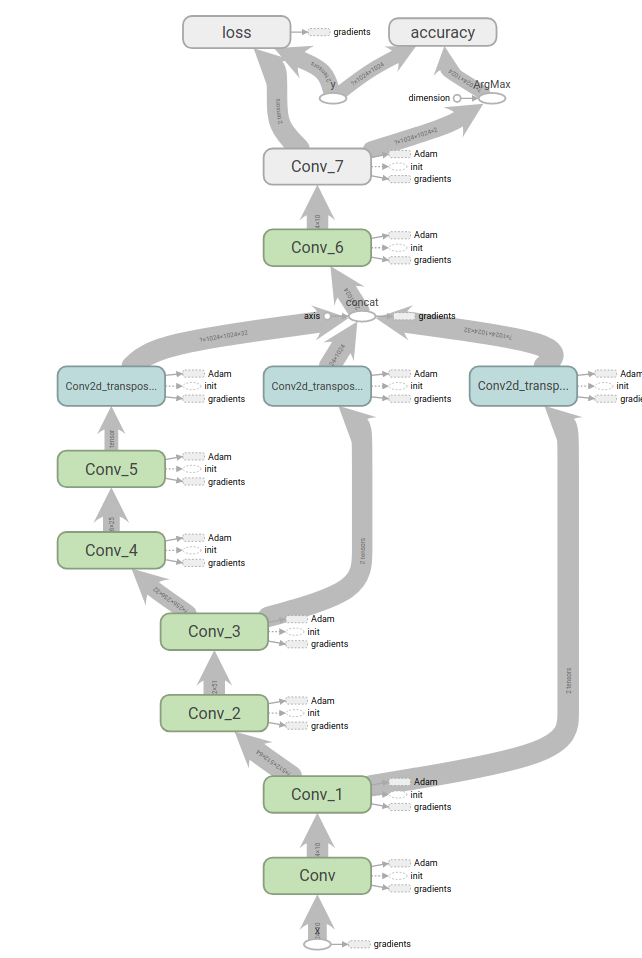

In [4]:
# My topology is somewhat similar to U-net. Each level of the network has multiple convolutional layers.
# Each successive level of the network reduces the size of the image (although I use striding rather
# than max pooling). The output of each level is passed through (after an inverse convolution to up sample
# to the original size) and concatinated so that the final convolutional layer has access to various high
# and low level image features. Note that the way I aggregate the various levels of my network is different
# than U-net. Rather than re-aggregate each level in a corresponding level, I simply pass the output of
# each level to a single concatination operation.
Image('topo.png')

In [5]:
# My cost function treats the output of my final convolution, which is a 1024x1024x2 tensor,
# as 1024x1024 unscaled log probabilities of cancer or not-cancer. I turn those log probabilities
# into probabilities using softmax and then compute a loss using cross entropy. I get a cross entropy
# value for each of the 1024x1024 pixels, so I aggregate them by taking the mean.
with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=s, labels=y))
train = tf.train.AdamOptimizer(1e-4).minimize(loss)

# Since the output 1024x1024x2 tensor gives per pixel scores of cancer or not-cancer, making
# predictions is simply the argmax with respect to the final axis. I then compute the percentage
# or per pixel predictions that match the per pixel labels.
accuracy = tf.contrib.metrics.accuracy(tf.argmax(s, axis=-1), y)

In [6]:
num_epochs = 10
batch_size = 5

train_size = len(train_xs)
test_interval = int(train_size / batch_size)
num_steps = test_interval * num_epochs

test_size = len(test_xs)
test_batches = np.array_split(np.arange(test_size), int(test_size / batch_size))

In [7]:
def make_summary(stats, prefix):  
    loss, accuracy = zip(*stats)
    return tf.Summary(value=[
        tf.Summary.Value(tag=prefix+'_loss', simple_value=np.mean(loss)),
        tf.Summary.Value(tag=prefix+'_accuracy', simple_value=np.mean(accuracy)),
    ])

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('logs', sess.graph)
    
    train_stats = []
    for step in trange(num_steps):
        batch = np.random.choice(train_size, batch_size, replace=False)
        _, stats = sess.run([train, [loss, accuracy]], {x: train_xs[batch], y: train_ys[batch]})
        train_stats.append(stats)

        if step % test_interval == 0:
            ss = make_summary(train_stats, 'train')
            writer.add_summary(ss, step)
            train_stats = []
            
            test_stats = []
            for batch in test_batches:
                stats = sess.run([loss, accuracy], {x: test_xs[batch], y: test_ys[batch]})
                test_stats.append(stats)
            ss = make_summary(test_stats, 'test')
            writer.add_summary(ss, step)
            
            writer.flush()
            
    display_y_hat = sess.run(s, {x: [display_x_white]})
    display_y_hat = np.argmax(display_y_hat[0], axis=-1)
    display_y_hat = (display_y_hat * 255).astype(np.uint8)

    writer.close()

100%|██████████| 1340/1340 [21:01<00:00,  1.06it/s]


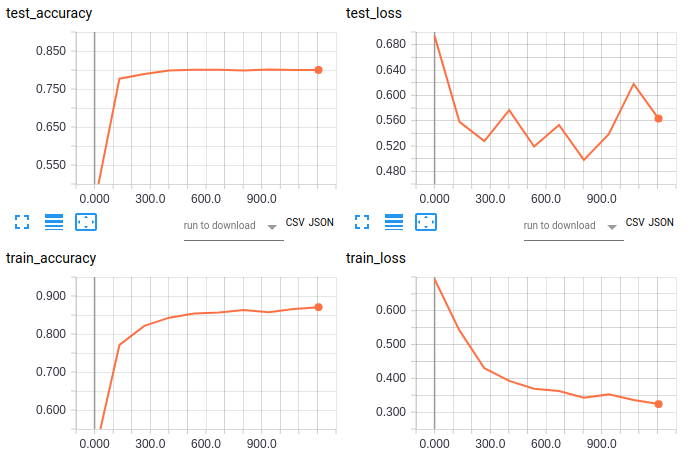

In [9]:
# With no regularization I achieve 87% accuracy on the training data, and 80% accuracy on the test data,
# meaning that I have 7% generalization error. Note that although my train loss nicely drops and flattens
# out, at some point my test loss starts going up, indicating that there my be some overfitting here.
Image('noreg-plot.png')

Input Image


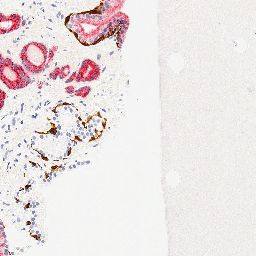

(1024, 1024) uint8
True Label


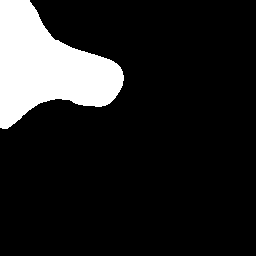

(1024, 1024) uint8
Predicted Label


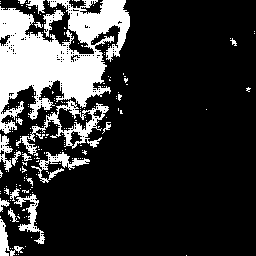

In [10]:
buf = io.BytesIO()
img = fromarray(display_x, 'RGB').resize((256, 256)).save(buf, 'png')
print('Input Image')
display(Image(buf.getvalue()))

buf = io.BytesIO()
print(display_y.shape, display_y.dtype)
img = fromarray(display_y).resize((256, 256)).save(buf, 'png')
print('True Label')
display(Image(buf.getvalue()))

buf = io.BytesIO()
print(display_y_hat.shape, display_y_hat.dtype)
img = fromarray(display_y_hat).resize((256, 256)).save(buf, 'png')
print('Predicted Label')
display(Image(buf.getvalue()))

In [11]:
# Ignoring good software development pricipals, I now do a bit of shameless
# copy-paste + modification to add L1 regularization to the previously described
# network. I use a lambda of of 0.2.
tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 1024, 1024, 3), name='x')
y = tf.placeholder(tf.int64, (None, 1024, 1024), name='y')

s = tf.contrib.layers.conv2d(x, 64, kernel_size=3)
s = tf.contrib.layers.conv2d(s, 64, kernel_size=3, stride=2)
a = tf.contrib.layers.conv2d_transpose(s, 32, kernel_size=3, stride=2)

s = tf.contrib.layers.conv2d(s, 32, kernel_size=3)
s = tf.contrib.layers.conv2d(s, 32, kernel_size=3, stride=2)
b = tf.contrib.layers.conv2d_transpose(s, 32, kernel_size=3, stride=4)

s = tf.contrib.layers.conv2d(s, 32, kernel_size=3)
s = tf.contrib.layers.conv2d(s, 32, kernel_size=3, stride=2)
c = tf.contrib.layers.conv2d_transpose(s, 32, kernel_size=3, stride=8)

s = tf.concat([a, b, c], -1)
s = tf.contrib.layers.conv2d(s, 32, kernel_size=3)
s = tf.contrib.layers.conv2d(s, 2, kernel_size=3, activation_fn=None)

with tf.name_scope('loss'):
    regularization = tf.contrib.layers.apply_regularization(
        tf.contrib.layers.l1_regularizer(.05),
        tf.trainable_variables(),
    )
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=s, labels=y)) + regularization
train = tf.train.AdamOptimizer(1e-4).minimize(loss)
accuracy = tf.contrib.metrics.accuracy(tf.argmax(s, axis=-1), y)

# batch_size = 5 from before was too big for my GPU :(
num_epochs = 10
batch_size = 3
train_size = len(train_xs)
test_interval = int(train_size / batch_size)
num_steps = test_interval * num_epochs
test_size = len(test_xs)
test_batches = np.array_split(np.arange(test_size), int(test_size / batch_size))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('logs', sess.graph)
    
    train_stats = []
    for step in trange(num_steps):
        batch = np.random.choice(train_size, batch_size, replace=False)
        _, stats = sess.run([train, [loss, accuracy]], {x: train_xs[batch], y: train_ys[batch]})
        train_stats.append(stats)

        if step % test_interval == 0:
            ss = make_summary(train_stats, 'train')
            writer.add_summary(ss, step)
            train_stats = []
            
            test_stats = []
            for batch in test_batches:
                stats = sess.run([loss, accuracy], {x: test_xs[batch], y: test_ys[batch]})
                test_stats.append(stats)
            ss = make_summary(test_stats, 'test')
            writer.add_summary(ss, step)
            
            writer.flush()
            
    display_y_hat = sess.run(s, {x: [display_x_white]})
    display_y_hat = np.argmax(display_y_hat[0], axis=-1)
    display_y_hat = (display_y_hat * 255).astype(np.uint8)

    writer.close()

100%|██████████| 2230/2230 [19:56<00:00,  1.86it/s]


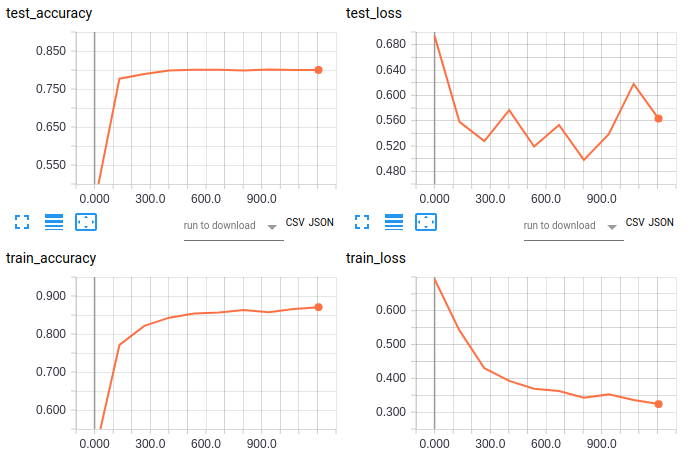

In [12]:
# With L1 regularization I achieve between 67 and 68% accuracy on the training data, and 76% accuracy on the test
# data, meaning that I have between -2% and -3% generalization error. This is actually lower than my
# non-regularized network.
Image('noreg-plot.png')

Input Image


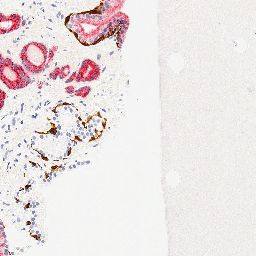

(1024, 1024) uint8
True Label


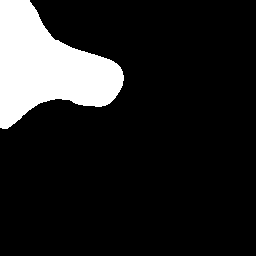

(1024, 1024) uint8
Predicted Label


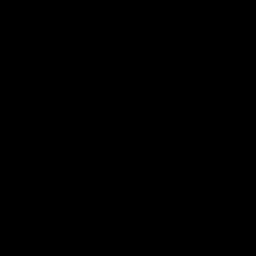

In [13]:
# The predictions for the L1-regularized network are less than impressive...
buf = io.BytesIO()
img = fromarray(display_x, 'RGB').resize((256, 256)).save(buf, 'png')
print('Input Image')
display(Image(buf.getvalue()))

buf = io.BytesIO()
print(display_y.shape, display_y.dtype)
img = fromarray(display_y).resize((256, 256)).save(buf, 'png')
print('True Label')
display(Image(buf.getvalue()))

buf = io.BytesIO()
print(display_y_hat.shape, display_y_hat.dtype)
img = fromarray(display_y_hat).resize((256, 256)).save(buf, 'png')
print('Predicted Label')
display(Image(buf.getvalue()))

In [14]:
# Finally, I do more copy pasting and reimplement my topology with drop out. I use a drop out probability of 0.2.
# I only use drop out on the layers in my network before the concatinate however.
tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 1024, 1024, 3), name='x')
y = tf.placeholder(tf.int64, (None, 1024, 1024), name='y')

s = tf.contrib.layers.conv2d(x, 64, kernel_size=3)
s = tf.nn.dropout(s, .2)
s = tf.contrib.layers.conv2d(s, 64, kernel_size=3, stride=2)
s = tf.nn.dropout(s, .2)
a = tf.contrib.layers.conv2d_transpose(s, 32, kernel_size=3, stride=2)
a = tf.nn.dropout(a, .2)

s = tf.contrib.layers.conv2d(s, 32, kernel_size=3)
s = tf.nn.dropout(s, .2)
s = tf.contrib.layers.conv2d(s, 32, kernel_size=3, stride=2)
s = tf.nn.dropout(s, .2)
b = tf.contrib.layers.conv2d_transpose(s, 32, kernel_size=3, stride=4)
b = tf.nn.dropout(b, .2)

s = tf.contrib.layers.conv2d(s, 32, kernel_size=3)
s = tf.nn.dropout(s, .2)
s = tf.contrib.layers.conv2d(s, 32, kernel_size=3, stride=2)
s = tf.nn.dropout(s, .2)
c = tf.contrib.layers.conv2d_transpose(s, 32, kernel_size=3, stride=8)
c = tf.nn.dropout(c, .2)

s = tf.concat([a, b, c], -1)
s = tf.contrib.layers.conv2d(s, 32, kernel_size=3)
s = tf.contrib.layers.conv2d(s, 2, kernel_size=3, activation_fn=None)

with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=s, labels=y))
train = tf.train.AdamOptimizer(1e-4).minimize(loss)
accuracy = tf.contrib.metrics.accuracy(tf.argmax(s, axis=-1), y)

# batch_size = 3 from L1 network was too big for my GPU :(
num_epochs = 10
batch_size = 1 
train_size = len(train_xs)
test_interval = int(train_size / batch_size)
num_steps = test_interval * num_epochs
test_size = len(test_xs)
test_batches = np.array_split(np.arange(test_size), int(test_size / batch_size))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('logs', sess.graph)
    
    train_stats = []
    for step in trange(num_steps):
        batch = np.random.choice(train_size, batch_size, replace=False)
        _, stats = sess.run([train, [loss, accuracy]], {x: train_xs[batch], y: train_ys[batch]})
        train_stats.append(stats)

        if step % test_interval == 0:
            ss = make_summary(train_stats, 'train')
            writer.add_summary(ss, step)
            train_stats = []
            
            test_stats = []
            for batch in test_batches:
                stats = sess.run([loss, accuracy], {x: test_xs[batch], y: test_ys[batch]})
                test_stats.append(stats)
            ss = make_summary(test_stats, 'test')
            writer.add_summary(ss, step)
            
            writer.flush()
            
    display_y_hat = sess.run(s, {x: [display_x_white]})
    display_y_hat = np.argmax(display_y_hat[0], axis=-1)
    display_y_hat = (display_y_hat * 255).astype(np.uint8)

    writer.close()

100%|██████████| 6710/6710 [27:21<00:00,  4.09it/s]


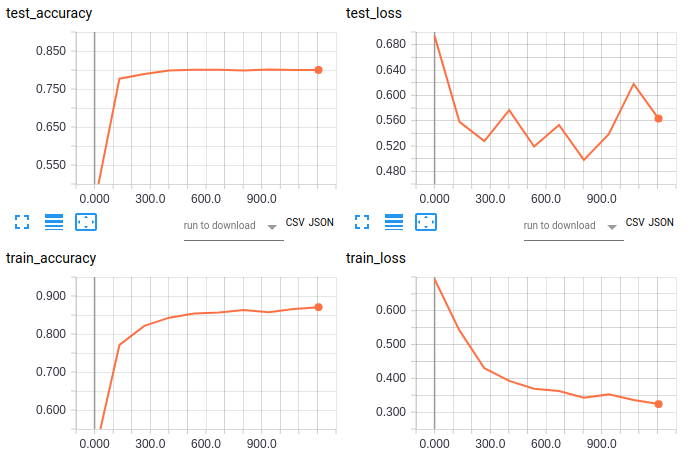

In [15]:
# With dropout I achieve between 85% accuracy on the training data, and 80% accuracy on the test
# data, meaning that I have 5% generalization error. While I get roughly the same test accuracy
# as the unregularized network, I am able to get less generalization error.
Image('noreg-plot.png')

Input Image


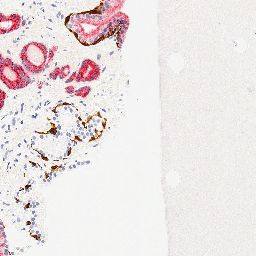

(1024, 1024) uint8
True Label


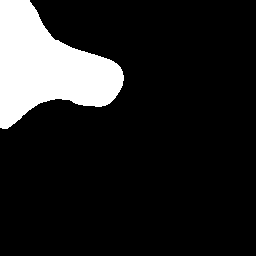

(1024, 1024) uint8
Predicted Label


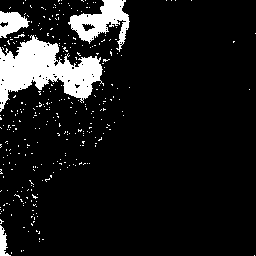

In [16]:
buf = io.BytesIO()
img = fromarray(display_x, 'RGB').resize((256, 256)).save(buf, 'png')
print('Input Image')
display(Image(buf.getvalue()))

buf = io.BytesIO()
print(display_y.shape, display_y.dtype)
img = fromarray(display_y).resize((256, 256)).save(buf, 'png')
print('True Label')
display(Image(buf.getvalue()))

buf = io.BytesIO()
print(display_y_hat.shape, display_y_hat.dtype)
img = fromarray(display_y_hat).resize((256, 256)).save(buf, 'png')
print('Predicted Label')
display(Image(buf.getvalue()))